In [1]:
%load_ext autoreload

In [132]:
%autoreload

In [2]:
import pandas as pd
from pathlib import Path
from typing import List, Dict
import darpinstances.instance
from darpinstances.db import db
import plotly.express as px

Successfully read db config from: ['C:\\Workspaces\\AIC\\Ridesharing_DARP_instances/config.ini']


In [26]:
# darp_dir_path = Path(r"C:/Google Drive/AIC Experiment Data/DARP")
itsc_dir_path = Path(r"C:/Google Drive/AIC Experiment Data/DARP/ITSC_instance_paper/Instances")
# itsc_dir_path = Path(r"D:/Google Drive/AIC Experiment Data/DARP/ITSC_instance_paper/Instances")

# fig_path = Path("D:/Workspaces/AIC/Ridesharing_DARP_instances/figures")
fig_path = Path("C:/Workspaces/AIC/Ridesharing_DARP_instances/figures")

area_dirs = [
    'NYC',
    'Manhattan',
    'Chicago',
    'DC'
]

areas = [
    dict(name='NYC', id=12, dataset_ids=[2, 3, 4, 5], srid=32618, zone_types=[2]),
    dict(name='Manhattan', id=4, dataset_ids=[2, 3, 4, 5], srid=32618, zone_types=[2]),
    dict(name='Chicago', id=19, dataset_ids=[1], srid=26916, zone_types=[0, 1]),
    dict(name='DC', id=22, dataset_ids=[7], srid=32618, zone_types=[4])
]

# Area table

In [67]:
edge_path = Path('C:\Google Drive\AIC Experiment Data\DARP\ITSC_instance_paper\Instances\Chicago\map/edges.csv')
edges = pd.read_csv(edge_path, sep='\t')
edges['length'].sum()

31982135.314356655

In [74]:
def get_data_for_dir(area_dir: str) -> Dict:
    area_dir_path = itsc_dir_path / Path(area_dir)
    map_dir = area_dir_path / Path('map')
    node_path = map_dir / Path('nodes.csv')
    edge_path = map_dir / Path('edges.csv')

    nodes = pd.read_csv(node_path, sep='\t')
    edges = pd.read_csv(edge_path, sep='\t')

    total_length = edges['length'].sum()

    area_data = {
        'area': area_dir,
        'node_count': len(nodes),
        'edge_count': len(edges),
        'Road length [km]': total_length / 1000,
    }

    # request count
    config = darpinstances.instance.load_instance_config(str(next(area_dir_path.rglob('config.yaml'))))
    demand_sets = config['demand']['dataset']
    area_id = config['area_id']
    # SELECT count(1) FROM demand
    #     WHERE
    #         dataset IN ({','.join((str(s) for s in demand_sets))})
    #         AND origin_time BETWEEN '2022-04-05 18:00:00' AND '2022-04-05 18:59:59'
    sql = f"""
    SELECT count(1) FROM demand
    JOIN trip_locations
        on demand.id = trip_locations.request_id
        AND dataset IN ({','.join((str(s) for s in demand_sets))})
        AND origin_time BETWEEN '2022-04-05 18:00:00' AND '2022-04-05 18:59:59'
    JOIN nodes origin_nodes
        ON origin_nodes.id = trip_locations.origin
    JOIN areas
        ON areas.id = {area_id}
        AND st_within(origin_nodes.geom, areas.geom)
    """
    req_count = db.execute_count_query(sql)
    area_data['Requests per hour'] = req_count

    # area
    sql = f"""
    SELECT st_area(st_transform(geom, 32618)) AS area
        FROM areas
        WHERE id = {area_id}
    """
    area = db.execute_count_query(sql)
    area_data['Area [km2]'] = area / 1000000

    return area_data

In [75]:
area_data_list = []
for area_dir in area_dirs:
    area_data = get_data_for_dir(area_dir)
    area_data_list.append(area_data)
area_data = pd.DataFrame(area_data_list)
area_data.rename(
    columns={
        'area': 'Area',
        'node_count': 'Node Count',
        'edge_count': 'Edge Count'
    },
    inplace=True
)
area_data

11:27:46 [INFO] Loading instance config from C:\Google Drive\AIC Experiment Data\DARP\ITSC_instance_paper\Instances\NYC\instances\start_18-00\duration_01_min\max_delay_03_min\config.yaml
11:27:46 [INFO] Connected (version 2.0, client OpenSSH_7.9p1)
11:27:46 [INFO] Auth banner: b'Debian GNU/Linux \n _ _          __      _                   _\n(_) |_ ___   / _| ___| |  _____   ___   _| |_   ___ ____\n| | __/ __| | |_ / _ \\ | / __\\ \\ / / | | | __| / __|_  /\n| | |_\\__ \\_|  _|  __/ || (__ \\ V /| |_| | |_ | (__ / /\n|_|\\__|___(_)_|  \\___|_(_)___| \\_/  \\__,_|\\__(_)___/___|\n\nWelcome to our ultra super duper cool server.\n\n'
11:27:46 [INFO] Authentication (publickey) successful!
11:27:49 [INFO] Loading instance config from C:\Google Drive\AIC Experiment Data\DARP\ITSC_instance_paper\Instances\Manhattan\instances\start_18-00\duration_01_min\max_delay_03_min\config.yaml
11:27:49 [INFO] Loading instance config from C:\Google Drive\AIC Experiment Data\DARP\ITSC_instance_paper\Instanc

,Area,Node Count,Edge Count,Road length [km],Requests per hour,Area [km2]
0,NYC,113411,281278,27720.535062,40294,1508.106916
1,Manhattan,6382,13455,1328.744618,23310,87.344297
2,Chicago,152653,413830,31982.135314,1138,1004.421323
3,DC,33230,84788,5876.597523,660,181.038363


In [34]:
area_data['Req./hour and km2'] = area_data['Requests per hour'] / area_data['Area [km2]']
area_data

,Area,Node Count,Edge Count,Requests per hour,Area [km2],Req./hour and km2
0,NYC,113411,281278,40294,1508.106916,26.718265
1,Manhattan,6382,13455,23310,87.344297,266.874894
2,Chicago,152653,413830,1138,1004.421323,1.132991
3,DC,33230,84788,660,181.038363,3.645636


In [76]:
s = area_data.style.format(escape='latex', precision=0)
s = s.hide(axis='index')
s = s.hide(['Requests per hour'], axis='columns')
print(s.to_latex())

\begin{tabular}{lrrrr}
Area & Node Count & Edge Count & Road length [km] & Area [km2] \\
NYC & 113411 & 281278 & 27721 & 1508 \\
Manhattan & 6382 & 13455 & 1329 & 87 \\
Chicago & 152653 & 413830 & 31982 & 1004 \\
DC & 33230 & 84788 & 5877 & 181 \\
\end{tabular}



# Demand density histogram

In [4]:
def get_data_for_area(id: int, dataset_ids: List[int], srid: int) -> pd.DataFrame:
    sql = f"""
    SELECT
        zones.id,
        min(zones.name) AS name,
        count(demand.id) AS demand_count,
        st_area(st_transform(min(zones.geom), {srid})) AS area
    FROM areas
        JOIN zones ON areas.id = {id} AND st_within(zones.geom, areas.geom)
        JOIN demand ON
            demand.dataset IN ({','.join((str(id) for id in dataset_ids))})
            AND zones.id = demand.origin
            AND demand.origin_time BETWEEN '2022-04-05 00:00:00' AND '2022-04-05 23:59:59'
    GROUP BY zones.id
    """
    return db.execute_query_to_pandas(sql)

In [5]:
df = pd.DataFrame()
for area in areas:
    print(f"Importing data for {area['name']}")
    df_area = get_data_for_area(area['id'], area['dataset_ids'], area['srid'])
    df_area['area_name'] = area['name']
    df = pd.concat([df, df_area])
df

15:53:20 [INFO] Connecting to ssh server


Importing data for NYC


15:53:22 [INFO] Connected (version 2.0, client OpenSSH_7.9p1)
15:53:22 [INFO] Auth banner: b'Debian GNU/Linux \n _ _          __      _                   _\n(_) |_ ___   / _| ___| |  _____   ___   _| |_   ___ ____\n| | __/ __| | |_ / _ \\ | / __\\ \\ / / | | | __| / __|_  /\n| | |_\\__ \\_|  _|  __/ || (__ \\ V /| |_| | |_ | (__ / /\n|_|\\__|___(_)_|  \\___|_(_)___| \\_/  \\__,_|\\__(_)___/___|\n\nWelcome to our ultra super duper cool server.\n\n'
15:53:22 [INFO] Authentication (publickey) successful!
15:53:22 [INFO] SSH tunnel established from ('127.0.0.1', 1113) to its.fel.cvut.cz/5432
15:53:22 [INFO] Starting _psycopg2 connection
15:53:24 [INFO] Starting sql_alchemy connection


Importing data for Manhattan
Importing data for Chicago
Importing data for DC


,id,name,demand_count,area,area_name
0,1,Newark Airport,25,7.338068e+06,NYC
1,3,Allerton/Pelham Gardens,1110,2.942011e+06,NYC
2,4,Alphabet City,1720,7.449769e+05,NYC
3,5,Arden Heights,163,4.680435e+06,NYC
4,6,Arrochar/Fort Wadsworth,293,3.800484e+06,NYC
...,...,...,...,...,...
1714,816865,1900 - 1999 BLOCK OF MASSACHUSETTS AVENUE SE,4,1.221537e+05,DC
1715,816873,1 - 49 BLOCK OF SUTTON SQUAE SW,8,4.172806e+03,DC
1716,816883,525 - 619 BLOCK OF WATER STREET SW,2,7.364737e+03,DC
1717,816888,1800 - 2099 BLOCK OF ASH ROAD SW,2,7.267198e+04,DC


In [6]:
df['demand_per_km2'] = df['demand_count'] * 1e6 / df['area']
# max = 24000
# df['demand_per_km2_gouped_outliers'] = [min(max, demand) for demand in df['demand_per_km2']]
df

,id,name,demand_count,area,area_name,demand_per_km2
0,1,Newark Airport,25,7.338068e+06,NYC,3.406892
1,3,Allerton/Pelham Gardens,1110,2.942011e+06,NYC,377.292912
2,4,Alphabet City,1720,7.449769e+05,NYC,2308.796538
3,5,Arden Heights,163,4.680435e+06,NYC,34.825823
4,6,Arrochar/Fort Wadsworth,293,3.800484e+06,NYC,77.095439
...,...,...,...,...,...,...
1714,816865,1900 - 1999 BLOCK OF MASSACHUSETTS AVENUE SE,4,1.221537e+05,DC,32.745642
1715,816873,1 - 49 BLOCK OF SUTTON SQUAE SW,8,4.172806e+03,DC,1917.175255
1716,816883,525 - 619 BLOCK OF WATER STREET SW,2,7.364737e+03,DC,271.564345
1717,816888,1800 - 2099 BLOCK OF ASH ROAD SW,2,7.267198e+04,DC,27.520924


In [7]:
size = 2000
bins = [i for i in range(0, df['demand_per_km2_gouped_outliers'].astype(int).max() + size, size)]
bins.append(25000)
cut = pd.cut(
    df['demand_per_km2_gouped_outliers'].astype(int),
    bins=bins,
    right=False
)
df['bin'] = cut
df_binned = df.groupby(['area_name', 'bin'])['bin'].count().reset_index(name='count')

area_sums = df_binned.groupby('area_name')['count'].sum().reset_index(name='sum')

df_binned = df_binned.merge(area_sums, on='area_name')
df_binned['percent'] = df_binned['count'] / df_binned['sum'] * 100
df_binned['x'] = df_binned['bin'].apply(lambda x: x.right - ((x.right - x.left) / 2))
df_binned.sort_values(['area_name'], inplace=True, ascending=False)
df_binned
# bins
# df_distances


KeyError: 'demand_per_km2_gouped_outliers'

In [8]:
def get_bins_per_area(area_df: pd.DataFrame):
    # area_df = pd.DataFrame(df[df['area_name'] == 'DC'])

    # # compute zone count
    # count = len(area_df)

    # compute maximum
    area_df.sort_values(['demand_per_km2'], inplace=True)
    # max_index = int(count * 0.99)
    # max = area_df.iloc[max_index]['demand_per_km2']
    max = area_df.iloc[-1]['demand_per_km2']

    # # decrease to max
    # area_df['demand_per_km2_gouped_outliers'] = [min(max, demand) for demand in area_df['demand_per_km2']]

    # compute size
    size = int(max / 10)

    # compute bins
    bins = [i for i in range(0, int(max) + size + 1, size)]

    # compute cut
    cut = pd.cut(
        area_df['demand_per_km2'].astype(int),
        bins=bins,
        # right=False
    )

    # compute binned
    area_df['bin'] = cut
    area_df_binned = area_df.groupby(['bin'])['demand_count'].sum().reset_index(name='count')
    # area_df
    # max
    # bins
    # int(max % size)

    # compute area sums
    area_sum = area_df_binned['count'].sum()

    # compute percent
    area_df_binned['percent'] = area_df_binned['count'] / area_sum * 100

    # compute x
    area_df_binned['x'] = area_df_binned['bin'].apply(lambda x: x.right - ((x.right - x.left) / 2))

    # area_df_binned
    return area_df_binned


df_binned = pd.DataFrame()
for area_name in df['area_name'].unique():
    area_df = pd.DataFrame(df[df['area_name'] == area_name])
    area_df_binned = get_bins_per_area(area_df)
    area_df_binned['area_name'] = area_name
    df_binned = pd.concat([df_binned, area_df_binned])
df_binned

,bin,count,percent,x,area_name
0,"(0, 2444]",326184,49.912931,1222.0,NYC
1,"(2444, 4888]",48654,7.445073,3666.0,NYC
2,"(4888, 7332]",46270,7.080272,6110.0,NYC
3,"(7332, 9776]",73721,11.280845,8554.0,NYC
4,"(9776, 12220]",59653,9.128149,10998.0,NYC
5,"(12220, 14664]",31793,4.864990,13442.0,NYC
6,"(14664, 17108]",13696,2.095773,15886.0,NYC
7,"(17108, 19552]",0,0.000000,18330.0,NYC
8,"(19552, 21996]",21514,3.292089,20774.0,NYC
9,"(21996, 24440]",32021,4.899879,23218.0,NYC


In [24]:
import plotly.graph_objects as go

fig = px.bar(
    df_binned,
    x='x',
    y='percent',
    facet_col='area_name',
    width=450,
    height=165,
)
# fig = px.histogram(
#     df,
#     'demand_per_km2_gouped_outliers',
#     facet_col='area_name',
#     nbins=5,
#     # log_x=True
#         width=600,
#         height=250,
# )
fig.update_xaxes(matches=None)

# faceting label editing
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.for_each_annotation(lambda a: a.update(text=''))

# shared annotation for axes
fig.for_each_xaxis(lambda y: y.update(title=''))
fig.add_annotation(x=0.5, y=-0.3, text="request count per km<sup>2</sup>", xref="paper", yref="paper", showarrow=False)
fig.for_each_yaxis(lambda y: y.update(title=''))
fig.add_annotation(x=-0.08, y=0.5, text="% of demand", xref="paper", yref="paper", showarrow=False, textangle=-90)

# manual x axis ticks
for i, area in enumerate(areas):
    vals_a = df_binned[df_binned['area_name'] == area['name']]['x'].values
    min = vals_a.min()
    max = vals_a.max()
    margin = 0.15 * max
    ticks = [
        min + margin,
        # min + ((max - min) / 2),
        max - margin
    ]
    ticks_t = [tick / 1000 for tick in ticks]
    rounded_ticks = [int(tick) for tick in ticks_t]
    if rounded_ticks[0] != rounded_ticks[1] and area['name'] != 'Chicago':
            # and rounded_ticks[1] != rounded_ticks[2]:
        ticks = [tick * 1000 for tick in rounded_ticks]
        texts = [f"{tick:d}k" for tick in rounded_ticks]
    else:
        texts = [f"{tick:.1f}k" for tick in ticks_t]
    fig.update_xaxes(row=1, col=i + 1, tickvals=ticks, ticktext=texts)

    for tick in ticks:
        fig.add_shape(
            go.layout.Shape(
                type="line",
                xref="x",
                yref="paper",
                x0=tick,
                y0=0,
                x1=tick,
                y1=100,
                line=dict(
                    color="White",
                    width=1
                )
            ),
            row=1,
            col=i + 1
        )

    print(f'{area["name"]}: col: {i}, ticks: {ticks}, max: {max}, min: {min}, margin: {margin}')

fig.update_layout(
    bargap=0.1
)

# set margins
fig.update_layout(margin=dict(l=0, r=0, t=15, b=0, pad=0))

fig

NYC: col: 0, ticks: [5000, 21000], max: 25662.0, min: 1222.0, margin: 3849.2999999999997
Manhattan: col: 1, ticks: [5000, 21000], max: 25662.0, min: 1222.0, margin: 3849.2999999999997
Chicago: col: 2, ticks: [329.92499999999995, 1419.075], max: 1669.5, min: 79.5, margin: 250.42499999999998
DC: col: 3, ticks: [27000, 116000], max: 137298.0, min: 6538.0, margin: 20594.7


In [27]:
path = fig_path / "demand_density.pdf"
print(f"Saving to {path}")
fig.write_image(path)

Saving to C:\Workspaces\AIC\Ridesharing_DARP_instances\figures\demand_density.pdf


In [37]:
fig_nyc = px.histogram(
    df[df['area_name'] == 'NYC'],
    'demand_per_km2',
    nbins=20
)
fig_nyc

In [39]:
df.sort_values('demand_per_km2', inplace=True, ascending=False)
df

,id,name,demand_count,area,area_name,demand_per_km2
82,800713,1900 - 1999 BLOCK OF CONNECTICUT AVENUE NW,832,6.362633e+03,DC,130763.482471
1690,816675,0 - 0 BLOCK OF COLUMBUS CIRCLE NE,1414,1.999868e+04,DC,70704.683213
101,800876,1 - 99 BLOCK OF MASSACHUSETTS AVENUE NE,316,6.970222e+03,DC,45335.712157
1353,812637,900 - 999 BLOCK OF MASSACHUSETTS AVENUE NW,332,7.712457e+03,DC,43047.240947
8,800098,400 - 499 BLOCK OF NEW JERSEY AVENUE NW,330,8.936785e+03,DC,36926.032723
...,...,...,...,...,...,...
61,64,CLEARING,4,6.604980e+06,Chicago,0.605604
50,51,SOUTH DEERING,17,2.820138e+07,Chicago,0.602807
69,72,BEVERLY,4,8.241752e+06,Chicago,0.485334
105,110,Great Kills Park,1,2.172192e+06,NYC,0.460365


# Trip length histogram

In [28]:
def get_trip_length_for_area(dataset_ids: List[int], zone_types: List[int], srid: int, area_id: int):
    print('Computing zone distances')
    sql = f"""
        CREATE TEMPORARY TABLE zones_distances AS (
            WITH zone_centorids AS (
                SELECT zones.id, st_centroid(st_transform(zones.geom, {srid})) as centroid
                FROM zones
                    JOIN areas ON areas.id = {area_id}
                        AND st_within(zones.geom, areas.geom)
                        AND type IN ({','.join((str(id) for id in zone_types))})
            )
            SELECT
                or_zones.id as or_id,
                de_zones.id as de_id,
                st_distance(or_zones.centroid, de_zones.centroid) AS distance
            FROM zone_centorids or_zones
                 JOIN zone_centorids de_zones ON TRUE
    );
    """
    db.execute_sql(sql)

    sql = f"""
        CREATE INDEX zones_distances_idx ON zones_distances (or_id, de_id);
    """
    db.execute_sql(sql)

    print('Computing trip lengths')
    sql = f"""
        SELECT distance
        FROM demand
        JOIN zones_distances ON
            demand.dataset IN ({','.join((str(id) for id in dataset_ids))})
            AND demand.origin_time BETWEEN '2022-04-05 00:00:00' AND '2022-04-05 23:59:59'
            AND zones_distances.or_id = demand.origin
            AND zones_distances.de_id = demand.destination
        """
    data = db.execute_query_to_pandas(sql)

    sql = """
        DROP TABLE zones_distances;
    """
    db.execute_sql(sql)

    return data

In [29]:
df_distances = pd.DataFrame()
for area in areas:
    print(f"Importing data for {area['name']}")
    df_area = get_trip_length_for_area(area['dataset_ids'], area['zone_types'], area['srid'], area['id'])
    df_area['area_name'] = area['name']
    df_distances = pd.concat([df_distances, df_area])
df_distances

Importing data for NYC
Computing zone distances
Computing trip lengths
Importing data for Manhattan
Computing zone distances
Computing trip lengths
Importing data for Chicago
Computing zone distances
Computing trip lengths
Importing data for DC
Computing zone distances
Computing trip lengths


,distance,area_name
0,0.000000,NYC
1,0.000000,NYC
2,0.000000,NYC
3,0.000000,NYC
4,0.000000,NYC
...,...,...
8431,1384.387971,DC
8432,4719.339690,DC
8433,3089.582564,DC
8434,1114.282270,DC


In [30]:
del min
df_distances['dist_km'] = df_distances['distance'] / 1000
df_distances['dist_km_lim'] = [min(dist, 20) for dist in df_distances['dist_km']]
df_distances

,distance,area_name,dist_km,dist_km_lim
0,0.000000,NYC,0.000000,0.000000
1,0.000000,NYC,0.000000,0.000000
2,0.000000,NYC,0.000000,0.000000
3,0.000000,NYC,0.000000,0.000000
4,0.000000,NYC,0.000000,0.000000
...,...,...,...,...
8431,1384.387971,DC,1.384388,1.384388
8432,4719.339690,DC,4.719340,4.719340
8433,3089.582564,DC,3.089583,3.089583
8434,1114.282270,DC,1.114282,1.114282


In [31]:
size = 2
bins = [i for i in range(0, df_distances['dist_km_lim'].astype(int).max() + size, size)]
bins.append(21)
cut = pd.cut(
    df_distances['dist_km_lim'].astype(int),
    bins=bins,
    right=False
)
df_distances['bin'] = cut
df_distances_binned = df_distances.groupby(['area_name', 'bin'])['bin'].count().reset_index(name='count')

area_sums = df_distances_binned.groupby('area_name')['count'].sum().reset_index(name='sum')
area_sums

df_distances_binned = df_distances_binned.merge(area_sums, on='area_name')
df_distances_binned['percent'] = df_distances_binned['count'] / df_distances_binned['sum'] * 100
df_distances_binned['x'] = df_distances_binned['bin'].apply(lambda x: x.right - ((x.right - x.left) / 2))
df_distances_binned.sort_values(['area_name'], inplace=True, ascending=False)
df_distances_binned
# bins
# df_distances


,area_name,bin,count,sum,percent,x
43,NYC,"[20, 21)",11609,631291,1.838930,20.5
38,NYC,"[10, 12)",18544,631291,2.937473,11.0
33,NYC,"[0, 2)",193374,631291,30.631515,1.0
35,NYC,"[4, 6)",91805,631291,14.542422,5.0
36,NYC,"[6, 8)",50378,631291,7.980155,7.0
37,NYC,"[8, 10)",33518,631291,5.309437,9.0
34,NYC,"[2, 4)",192455,631291,30.485941,3.0
39,NYC,"[12, 14)",14019,631291,2.220687,13.0
40,NYC,"[14, 16)",10199,631291,1.615578,15.0
41,NYC,"[16, 18)",7756,631291,1.228593,17.0


In [45]:
# dist_fig = px.histogram(
#     df_distances_binned,
#     'bin',
#     nbins=20,
#     facet_col='area_name',
#     histnorm='percent',
#     width=600,
#     height=250,
# )
dist_fig = px.bar(
    df_distances_binned,
    x='x',
    y='percent',
    facet_col='area_name',
    width=450,
    height=150,
)

# faceting label editing
# dist_fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
dist_fig.for_each_annotation(lambda a: a.update(text=''))

# shared annotation for axes
dist_fig.for_each_xaxis(lambda y: y.update(title=''))
dist_fig.add_annotation(x=0.5, y=-0.3, text="trip distance [km]", xref="paper", yref="paper", showarrow=False)
dist_fig.for_each_yaxis(lambda y: y.update(title=''))
dist_fig.add_annotation(x=-0.08, y=0.5, text="% of trips", xref="paper", yref="paper", showarrow=False, textangle=-90)

dist_fig.update_layout(
    bargap=0.1
)

ticks = [10, 20]
    # list(range(5, 20, 5)) + [20]
        # [20.5]

# x tick labels
dist_fig.for_each_xaxis(lambda x: x.update(
    tickmode='array',
    tickvals=ticks,
    # ticktext=[str(i) for i in range(5, 20, 5)] + ['20+']
    ticktext=['10', '20+']
))

for i in range(len(areas)):
    for tick in ticks:
        dist_fig.add_shape(
            go.layout.Shape(
                type="line",
                xref="x",
                yref="paper",
                x0=tick,
                y0=0,
                x1=tick,
                y1=50,
                line=dict(
                    color="White",
                    width=1
                )
            ),
            row=1,
            col=i + 1
        )

# set margins
dist_fig.update_layout(margin=dict(l=0, r=10, t=0, b=0, pad=0))

dist_fig

In [46]:
path = fig_path / "trip_length.pdf"
print(f"Saving to {path}")
dist_fig.write_image(path)

Saving to C:\Workspaces\AIC\Ridesharing_DARP_instances\figures\trip_length.pdf


# Instance comparison table
Collect metrics on our instances and compare them to the classical DARP instances.
Metrics:
- Number of requests
- Number of vehicles
- Average trip length
- Instance duration
- Requests per hour
- Requests per hour and km2 - only to show this does not make sense in classical darp
- Area - only to show this does not make sense in classical darp

In [37]:
from pathlib import Path
import pandas as pd
from io import StringIO
from dataclasses import dataclass
import numpy as np
import logging
from darpinstances.utils import load_yaml
import matplotlib.pyplot as plt
from abc import abstractmethod, ABC

In [3]:
@dataclass
class ResultsRow:
    instance: str
    instance_duration: str
    num_requests: str
    num_vehicles: str
    avg_trip_length: str
    time_window_lengths: str

tbl = []

## Classical DARP instances

### Branch and Cut

Filename: described in paper, config-num_requests
Content:

```txt
filename: a2-20

first row:
vehicle_count request_count ? ? ?
2 20 600 3 30
following rows:
index   x_loc y_loc ?   loc min_time_minutes max_time_minutes
  0   0.000   0.000   0   0    0  600
  1  -4.374  -7.608   3   1    0 1440
  2  -1.990  -1.658   3   1    0 1440
  3  -6.500   8.666   3   1    0 1440
```
loc meaning: `1`: origin, `-1`: destination, `0`: depot

In [ ]:
classical_instances_path = Path(r"C:\Users\mrkos\scth\projects\2023_ITSC_DARP_instances_paper\experiments\instances_classical_DARP")

In [56]:
class ClassicalDARPInstance(ABC):
    trips_col_names = ["index", "x_loc", "y_loc", "_", "loc", "min_time_minutes", "max_time_minutes"]
    CFG=None # Needs to be set up by child class
    def __init__(self, file: Path):
        self.filename = file
        self.cfg = None
        self.all_trips = None
        self.read_file(file)

    def read_file(self, file: Path):
        try:
            with open(file, "rt", encoding="utf-8") as f:
                cfg = list(map(int, f.readline().strip().split(" ")))
                trips = f.read()
        except Exception as e:
            logging.error(f"Problem reading file {file}")
            raise e
        self.cfg = self.CFG(*cfg)
        self.all_trips = pd.read_csv(StringIO(trips), delim_whitespace=True, header=None, names=self.trips_col_names)

    @property
    def trips(self):
        """Trips excluding trips to depot"""
        try:
            return self.all_trips.loc[self.all_trips["loc"] != 0, :]
        except pd.core.indexing.IndexingError as e:
            logging.error(f"Problem selecting trips from\n{self.all_trips}")
            raise e

    def get_trip_distances_minutes(self):
        origins = self.trips.loc[self.trips["loc"] == 1, ["x_loc", "y_loc"]]
        destinations = self.trips.loc[self.trips["loc"] == -1, ["x_loc", "y_loc"]]
        return np.linalg.norm(origins.values - destinations.values, axis=1)

    def get_timewindows_minutes(self):
        tw = inst.trips["max_time_minutes"] - inst.trips["min_time_minutes"]
        tw.name="timewindow_minutes"
        return tw

    @abstractmethod
    def request_count(self):
        pass

@dataclass
class BaC_cfg:
    vehicle_count: int
    request_count: int
    _1: int
    _2: int
    _3: int

class BaC(ClassicalDARPInstance):
    CFG = BaC_cfg

    @property
    def request_count(self):
        return self.cfg.request_count



file = Path(r"C:\Users\mrkos\scth\projects\2023_ITSC_DARP_instances_paper\experiments\instances_classical_DARP\branch-and-cut\a2-16")
inst = BaC(file)
inst.get_trip_distances_minutes();
inst.get_timewindows_minutes();

In [57]:
bac_instances = [BaC(filepath) for filepath in (classical_instances_path/"branch-and-cut").rglob("*")]
len(bac_instances)

48

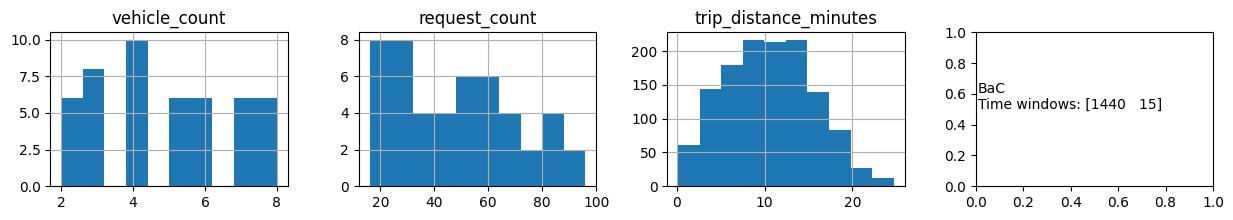

In [58]:
def classical_instance_stats(instances):
    fig, axes = plt.subplots(1, 4, figsize=(15, 2))
    vehicle_count = pd.DataFrame([bac.cfg.vehicle_count for bac in instances], columns=("vehicle_count",))
    vehicle_count.hist(ax = axes[0])
    request_count = pd.DataFrame([bac.request_count for bac in instances], columns=("request_count",))
    request_count.hist(ax = axes[1])
    trip_distance_minutes=pd.DataFrame(np.concatenate([bac.get_trip_distances_minutes() for bac in instances]), columns=("trip_distance_minutes",))
    trip_distance_minutes.hist(ax = axes[2])
    time_window_lengths = pd.concat([bac.get_timewindows_minutes() for bac in instances]).unique()
    ax = axes[3].text(0.01, 0.5, f"BaC\nTime windows: {time_window_lengths}")
    return vehicle_count, request_count, trip_distance_minutes, time_window_lengths

vehicle_count, request_count, trip_distance_minutes, time_window_lengths = classical_instance_stats(bac_instances);

In [59]:
classical_darp = ResultsRow(
    instance=r"$^a$Classical DARPs\cite{cordeauBranchandCutAlgorithmDialaRide2006}",
    instance_duration="24 h",
    num_requests=f"{min(request_count.request_count)}-{max(request_count.request_count)}",
    num_vehicles=f"{min(vehicle_count.vehicle_count)}-{max(vehicle_count.vehicle_count)}",
    avg_trip_length=f"{trip_distance_minutes.trip_distance_minutes.mean():.1f}$\pm${trip_distance_minutes.trip_distance_minutes.std():.1f}",
    time_window_lengths=r"15 min or 24 h$^c$"
)

classical_ress = []
classical_ress.append(classical_darp.__dict__)

### TABU search

```text
3 48 480 6 90
  0   -1.044    2.000  0  0    0 1440
  1   -2.973    6.414 10  1    0 1440
  2   -3.066    0.546 10  1    0 1440
  3    5.164    0.547 10  1    0 1440
```

Instances description:
The randomlygenerated instances contain between 24 and 144 requests. For an n request in-
stance, requests 1; . . . ; n=2 are assumed to be outbound while requests n=2 þ 1; . . . ; n are assumed
to be inbound. For each instance, origin and destination locations were generated byusing a
procedure, previouslydescribed byCordeau et al. (1997), that creates clusters of vertices around a
certain number of seed points. For an instance with n requests, 2n vertices are generated in the
square [ 10; 10]2 with this procedure. For i ¼ 1; . . . ; n, vertex v i is the origin of request i while
vertex vnþi is its destination. For each vertex, the service time d i is equal to 10 and the load
qi is equal either to 1 or 1 depending on whether the vertex corresponds to the origin or
the destination of a request. The location of the depot is equal to the average location of the
seed points used to generate origin and destination locations. For everyarc ðvi; vjÞ 2 A, the routing
cost cij and travel time t ij are equal to the Euclidean distance between the two ver-tices.
A time window [e i; l i] is also associated to each vertex. As mentioned in Section 4, origin
vertices of outbound requests and destination vertices of inbound requests have trivial time
windows [0; T ], where T denotes the end of the planning horizon (equal to 24 60 ¼ 1440 in our
experiments). Two groups of instances were created byusing different parameters for generating
time windows. In the first group (a), narrow time windows were generated byfirst choosing a
uniform random number ei in the interval [60, 480] and then choosing a uniform random number
li in the interval [e i þ 15; e i þ 45]. In the second group (b), wider time windows were created by
choosing the random numbers e i and li in the intervals [60, 480] and [ei þ 30; e i þ 90], respectively.
In all instances, maximum route duration is set to 480 while the capacityof a vehicle is equal to 6.
Finally, the maximum ride time L is equal to 90.

In [60]:
@dataclass
class Tabu_cfg:
    vehicle_count: int
    vertices_count: int
    _1: int
    _2: int
    _3: int

class Tabu(ClassicalDARPInstance):
    CFG = Tabu_cfg

    @property
    def request_count(self):
        return self.cfg.vertices_count / 2

file = Path(r"C:\Users\mrkos\scth\projects\2023_ITSC_DARP_instances_paper\experiments\instances_classical_DARP\tabu\pr01")
inst = Tabu(file)
inst.get_trip_distances_minutes()
inst.get_timewindows_minutes();

In [61]:
tabu_instances = [Tabu(filepath) for filepath in (classical_instances_path/"tabu").rglob("*") if filepath.suffix != ".res"]
len(tabu_instances)

20

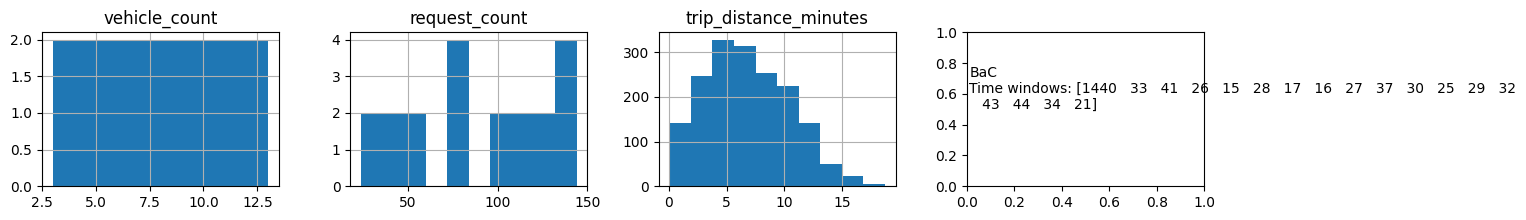

In [62]:
vehicle_count, request_count, trip_distance_minutes, time_window_lengths = classical_instance_stats(tabu_instances);

In [63]:
vehicle_count.vehicle_count.unique()

array([ 3,  5,  7,  9, 11, 13,  4,  6,  8, 10], dtype=int64)

In [64]:
classical_darp = ResultsRow(
    instance=r"$^d$Classical DARPs\cite{kirchlerGranularTabuSearch2013}",
    instance_duration="24 h",
    num_requests=f"{min(request_count.request_count)}-{max(request_count.request_count)}",
    num_vehicles=f"{min(vehicle_count.vehicle_count)}-{max(vehicle_count.vehicle_count)}",
    avg_trip_length=f"{trip_distance_minutes.trip_distance_minutes.mean():.1f}$\pm${trip_distance_minutes.trip_distance_minutes.std():.1f}",
    time_window_lengths=r"24 h, 15-45 min$^c$ or 24 h, 30-90 min$^c$"
)

classical_ress = []
classical_ress.append(classical_darp.__dict__)

## Our instances

In [65]:
our_instances_path = Path(r"C:\Users\mrkos\scth\projects\2023_ITSC_DARP_instances_paper\experiments\instances\Instances")

In [66]:
class DARPInstance():
    def __init__(self, instance_folder:Path):
        self.instance_folder = instance_folder
        self.cfg = load_yaml(self.instance_folder/"config.yaml")
        self.trips = pd.read_csv(self.instance_folder/"trips.csv", header=0, sep="\t")
        self.vehicles=pd.read_csv(self.instance_folder/"vehicles.csv", header=None, sep="\t", names=["origin", "capacity"])

    @property
    def vehicle_count(self):
        return len(self.vehicles)

    @property
    def request_count(self):
        return len(self.trips)

    def get_trip_distances_minutes(self):
        return self.trips.loc[:, "min_travel_time"]/60


cfg_path = Path(r"C:\Users\mrkos\scth\projects\2023_ITSC_DARP_instances_paper\experiments\instances\Instances\Chicago\instances\start_18-00\duration_05_min\max_delay_03_min\config.yaml")

di = DARPInstance(cfg_path.parent)
di.trips
di.vehicles
di.vehicle_count
di.request_count
di.get_trip_distances_minutes();

ResultsRow(instance='DC', instance_duration='5 min', num_requests='54', num_vehicles='50', avg_trip_length='15.2$\\pm$9.8min', time_window_lengths='3, 5 or 10$^b$')

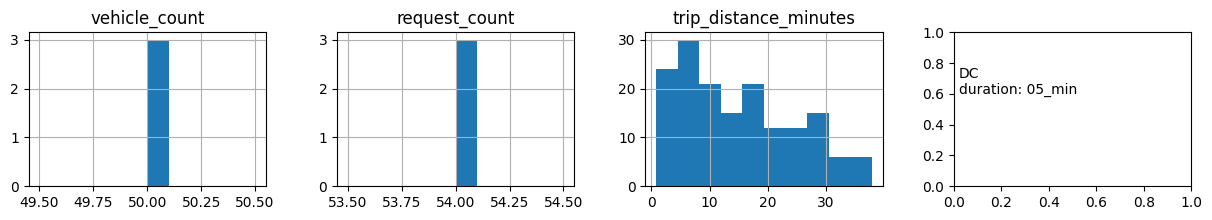

In [70]:
def instance_stats(darp_instances):
    fig, axes = plt.subplots(1, 4, figsize=(15, 2))
    vehicle_count = pd.DataFrame([di.vehicle_count for di in darp_instances], columns=("vehicle_count",))
    vehicle_count.hist(ax=axes[0])
    request_count = pd.DataFrame([di.request_count for di in darp_instances], columns=("request_count",))
    request_count.hist(ax=axes[1])
    trip_distance_minutes = pd.DataFrame(np.concatenate([di.get_trip_distances_minutes() for di in darp_instances]), columns=("trip_distance_minutes",))
    trip_distance_minutes.hist(ax=axes[2])
    return vehicle_count, request_count, trip_distance_minutes, axes


def get_results_row(city:str, duration:str):
    darp_instances = [DARPInstance(cfg_path.parent) for cfg_path in our_instances_path.rglob(f"**/{city}/*/*/*duration_{duration}*/*/config.yaml")]
    vehicle_count, request_count, trip_distance_minutes, axes = instance_stats(darp_instances)
    axes[-1].text(0.02,0.6,f"{city}\nduration: {duration}")

    res = ResultsRow(
        instance=city,
        instance_duration=f"{int(duration.split('_')[0])} {duration.split('_')[1]}",
        num_requests=f"{request_count.request_count.mean():.0f}",
        num_vehicles=f"{vehicle_count.vehicle_count.mean():.0f}",
        avg_trip_length=f"{trip_distance_minutes.trip_distance_minutes.mean():.1f}$\pm${trip_distance_minutes.trip_distance_minutes.std():.1f}min",
        time_window_lengths=r"3, 5 or 10$^b$"
    )
    return res


get_results_row("DC", "05_min")
# tbl.append(get_results_row("DC", "05_min").__dict__)


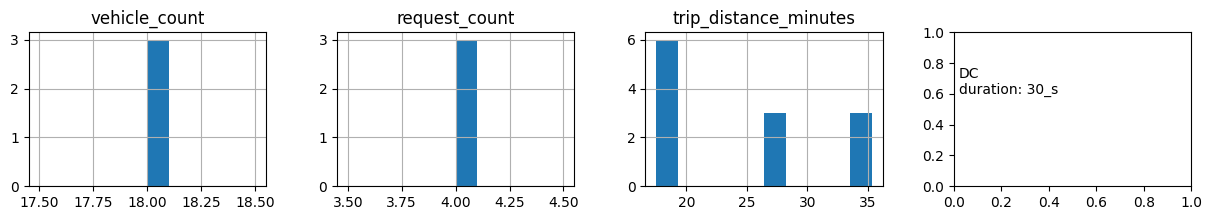

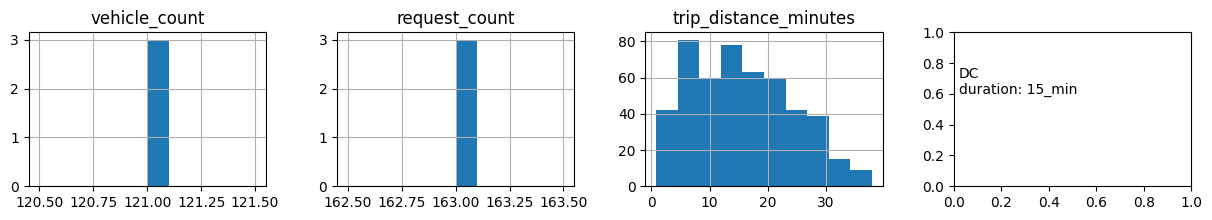

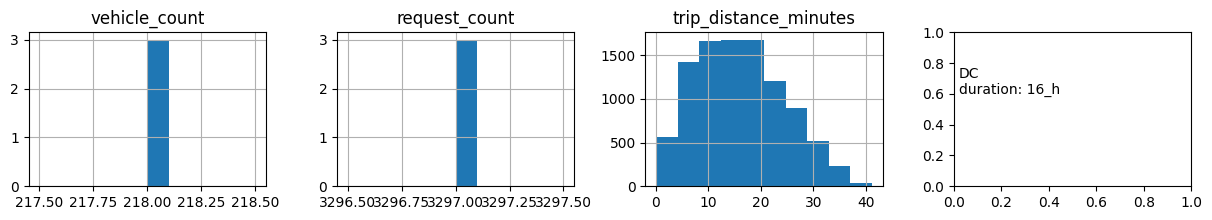

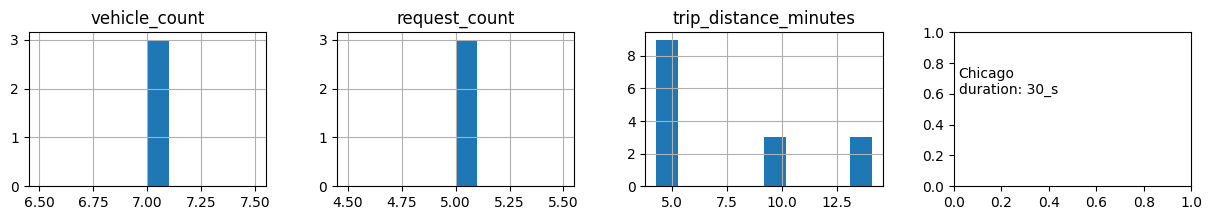

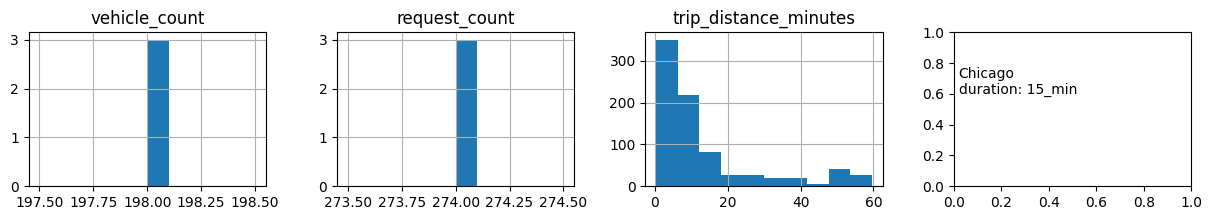

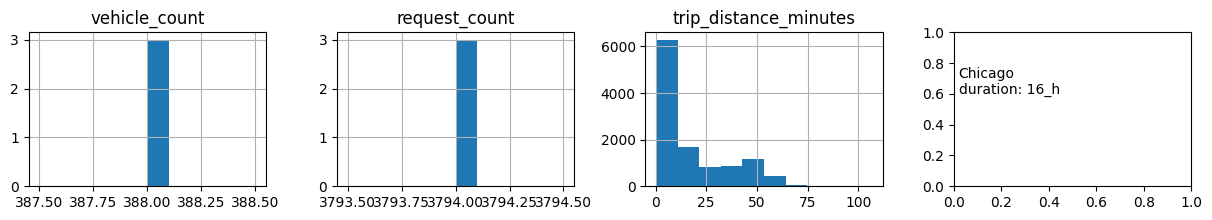

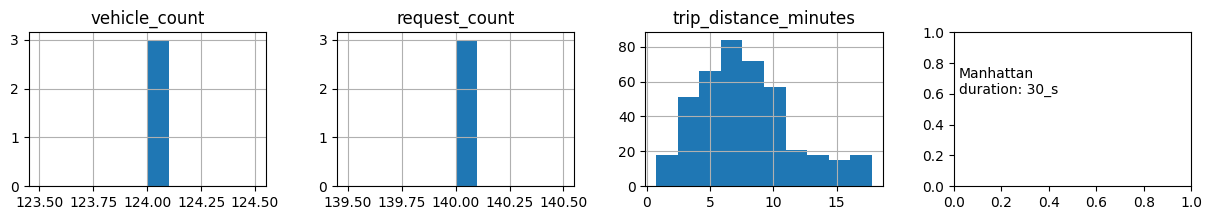

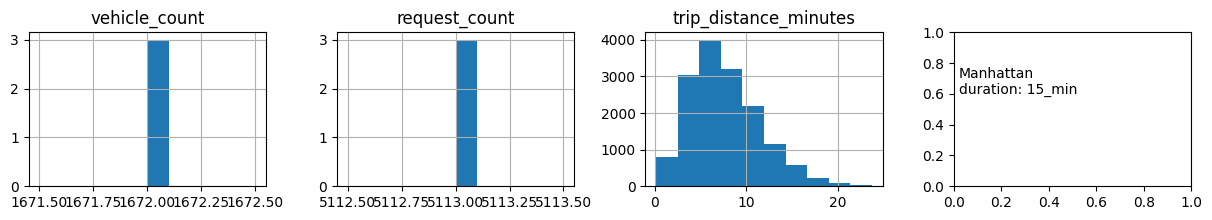

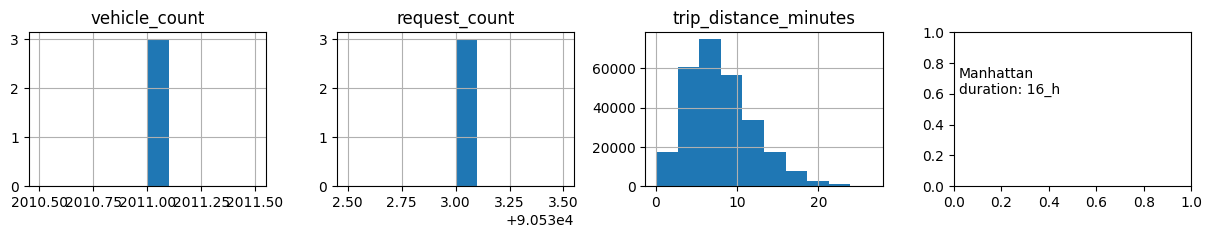

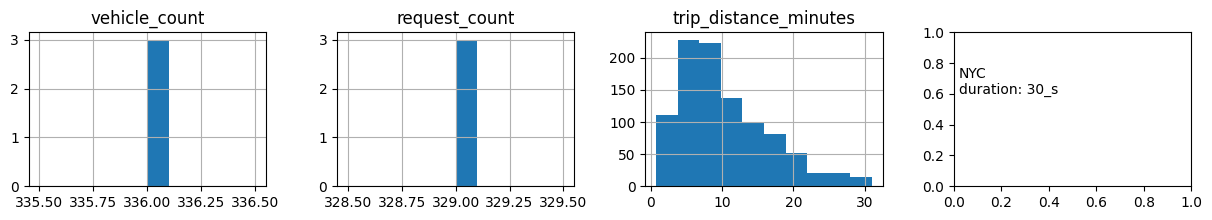

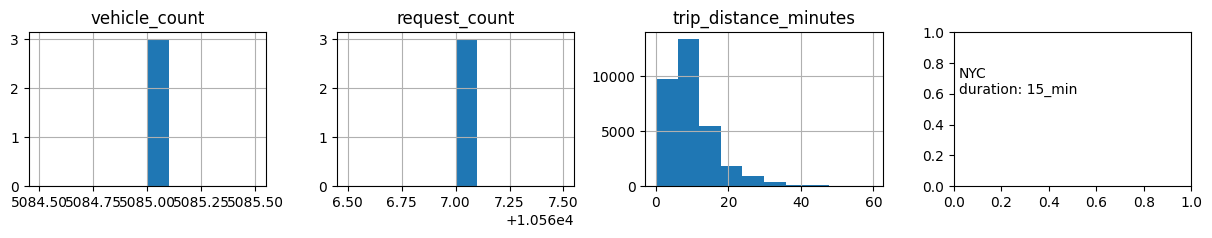

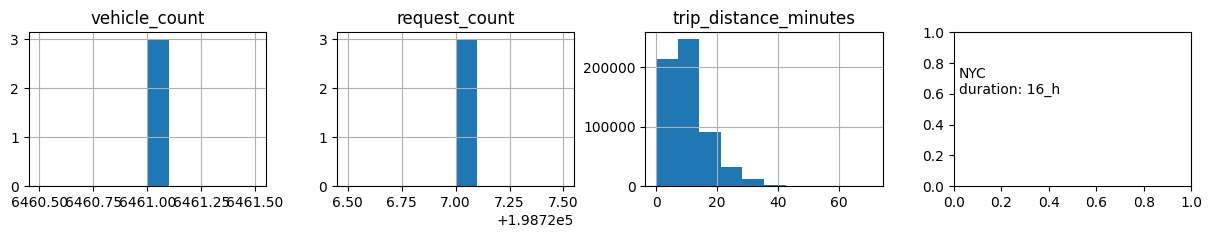

In [71]:
ress = []
ress.append(get_results_row("DC", "30_s"))
ress.append(get_results_row("DC", "15_min"))
ress.append(get_results_row("DC", "16_h"))

ress.append(get_results_row("Chicago", "30_s"))
ress.append(get_results_row("Chicago", "15_min"))
ress.append(get_results_row("Chicago", "16_h"))

ress.append(get_results_row("Manhattan", "30_s"))
ress.append(get_results_row("Manhattan", "15_min"))
ress.append(get_results_row("Manhattan", "16_h"))

ress.append(get_results_row("NYC", "30_s"))
ress.append(get_results_row("NYC", "15_min"))
ress.append(get_results_row("NYC", "16_h"))

our_ress = [res.__dict__ for res in ress]


## Results table


In [72]:
tbl = pd.DataFrame.from_dict(our_ress + classical_ress)
tbl

,instance,instance_duration,num_requests,num_vehicles,avg_trip_length,time_window_lengths
0,DC,30 s,4,18,25.0$\pm$7.5min,"3, 5 or 10$^b$"
1,DC,15 min,163,121,15.8$\pm$8.7min,"3, 5 or 10$^b$"
2,DC,16 h,3297,218,16.1$\pm$8.3min,"3, 5 or 10$^b$"
3,Chicago,30 s,5,7,7.3$\pm$4.0min,"3, 5 or 10$^b$"
4,Chicago,15 min,274,198,13.4$\pm$15.1min,"3, 5 or 10$^b$"
5,Chicago,16 h,3794,388,17.8$\pm$17.9min,"3, 5 or 10$^b$"
6,Manhattan,30 s,140,124,7.9$\pm$3.7min,"3, 5 or 10$^b$"
7,Manhattan,15 min,5113,1672,7.7$\pm$3.8min,"3, 5 or 10$^b$"
8,Manhattan,16 h,90533,2011,8.0$\pm$4.0min,"3, 5 or 10$^b$"
9,NYC,30 s,329,336,10.3$\pm$6.2min,"3, 5 or 10$^b$"


In [73]:
print(tbl.to_latex(index=False, caption="Comparison of selected proposed instances and classical DARP instances", label="tab:instances",
                   header=["Instances", "Duration", "Requests", "Vehicles", "Trip Length [mean$\pm$std min]", "Time Window Lengths"]))

\begin{table}
\caption{Comparison of selected proposed instances and classical DARP instances}
\label{tab:instances}
\begin{tabular}{llllll}
\toprule
Instances & Duration & Requests & Vehicles & Trip Length [mean$\pm$std min] & Time Window Lengths \\
\midrule
DC & 30 s & 4 & 18 & 25.0$\pm$7.5min & 3, 5 or 10$^b$ \\
DC & 15 min & 163 & 121 & 15.8$\pm$8.7min & 3, 5 or 10$^b$ \\
DC & 16 h & 3297 & 218 & 16.1$\pm$8.3min & 3, 5 or 10$^b$ \\
Chicago & 30 s & 5 & 7 & 7.3$\pm$4.0min & 3, 5 or 10$^b$ \\
Chicago & 15 min & 274 & 198 & 13.4$\pm$15.1min & 3, 5 or 10$^b$ \\
Chicago & 16 h & 3794 & 388 & 17.8$\pm$17.9min & 3, 5 or 10$^b$ \\
Manhattan & 30 s & 140 & 124 & 7.9$\pm$3.7min & 3, 5 or 10$^b$ \\
Manhattan & 15 min & 5113 & 1672 & 7.7$\pm$3.8min & 3, 5 or 10$^b$ \\
Manhattan & 16 h & 90533 & 2011 & 8.0$\pm$4.0min & 3, 5 or 10$^b$ \\
NYC & 30 s & 329 & 336 & 10.3$\pm$6.2min & 3, 5 or 10$^b$ \\
NYC & 15 min & 10567 & 5085 & 9.9$\pm$6.6min & 3, 5 or 10$^b$ \\
NYC & 16 h & 198727 & 6461 & 10.5$